# Statement

The Sure Tomorrow insurance company wants to solve several tasks with the help of Machine Learning and you are asked to evaluate that possibility.

- Task 1: Find customers who are similar to a given customer. This will help the company's agents with marketing.
- Task 2: Predict whether a new customer is likely to receive an insurance benefit. Can a prediction model do better than a dummy model?
- Task 3: Predict the number of insurance benefits a new customer is likely to receive using a linear regression model.
- Task 4: Protect clients' personal data without breaking the model from the previous task. It's necessary to develop a data transformation algorithm that would make it hard to recover personal information if the data fell into the wrong hands. This is called data masking, or data obfuscation. But the data should be protected in such a way that the quality of machine learning models doesn't suffer. You don't need to pick the best model, just prove that the algorithm works correctly.

# Data Preprocessing & Exploration

## Initialization

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats as st
import math

import seaborn as sns

import sklearn.linear_model
import sklearn.metrics
import sklearn.neighbors
import sklearn.preprocessing

from sklearn.model_selection import train_test_split

from IPython.display import display

## Load Data

Load data and conduct a basic check that it's free from obvious issues.

In [2]:
df = pd.read_csv('/datasets/insurance_us.csv')

We rename the colums to make the code look more consistent with its style.

In [3]:
df = df.rename(columns={'Gender': 'gender', 'Age': 'age', 'Salary': 'income', 'Family members': 'family_members', 'Insurance benefits': 'insurance_benefits'})

In [4]:
df.sample(10)

,gender,age,income,family_members,insurance_benefits
2450,1,33.0,43700.0,2,0
4195,1,47.0,28000.0,2,1
2992,0,47.0,37900.0,0,1
2243,0,27.0,34200.0,2,0
792,1,38.0,38200.0,1,0
3037,1,44.0,49900.0,0,1
1407,1,26.0,43700.0,0,0
2891,0,45.0,51200.0,0,1
3398,1,28.0,67100.0,1,0
3127,0,47.0,49700.0,1,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   float64
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [6]:
# we may want to fix the age type (from float to int) though this is not critical

# write your conversion here if you choose:

if np.all(df['age'] == df['age'].astype(int)): df['age'] = df['age'].astype(int)

In [7]:
# check to see that the conversion was successful

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   int64  
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(1), int64(4)
memory usage: 195.4 KB


In [8]:
# now have a look at the data's descriptive statistics. 
# Does everything look okay?

for col in df:
    display(df[col].describe())

count    5000.000000
mean        0.499000
std         0.500049
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: gender, dtype: float64

count    5000.000000
mean       30.952800
std         8.440807
min        18.000000
25%        24.000000
50%        30.000000
75%        37.000000
max        65.000000
Name: age, dtype: float64

count     5000.000000
mean     39916.360000
std       9900.083569
min       5300.000000
25%      33300.000000
50%      40200.000000
75%      46600.000000
max      79000.000000
Name: income, dtype: float64

count    5000.000000
mean        1.194200
std         1.091387
min         0.000000
25%         0.000000
50%         1.000000
75%         2.000000
max         6.000000
Name: family_members, dtype: float64

count    5000.000000
mean        0.148000
std         0.463183
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         5.000000
Name: insurance_benefits, dtype: float64

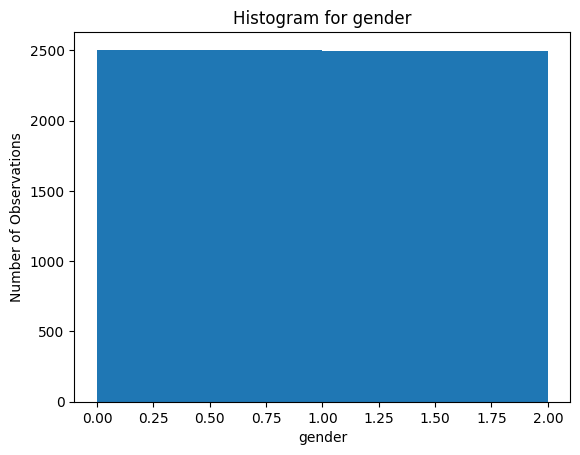

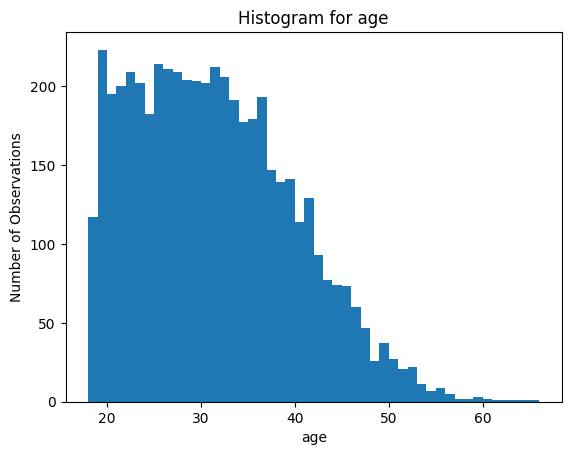

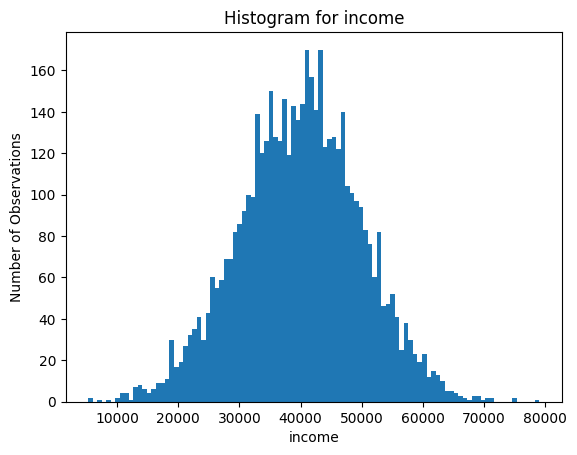

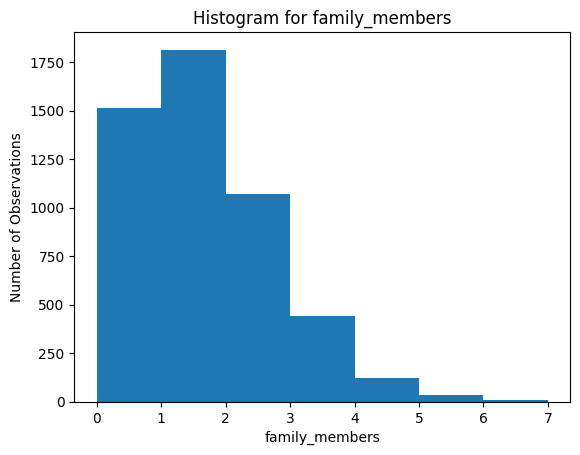

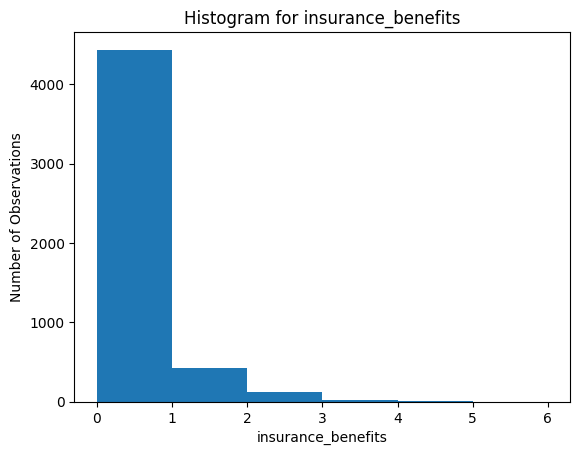

In [9]:
# Create a function to examine column distributions and plot each column

def histo(df, column):
    unique_values = np.sort(df[column].unique())
    if (len(unique_values) < 100): 
        bins = np.append(unique_values, unique_values[-1] + 1) 
    else: 
        bins = 100

    plt.hist(df[column], bins=bins)
    plt.xlabel(column)
    plt.ylabel('Number of Observations')
    plt.title(f'Histogram for {column}')
    plt.show()
    
for col in df:
    histo(df, col)

In [10]:
# Examine values with large frequencies

df['insurance_benefits'].value_counts().sort_index()

0    4436
1     423
2     115
3      18
4       7
5       1
Name: insurance_benefits, dtype: int64

The data look good overall with no obvious distributional issues. The gender column is almost perfectly split between classes and the income column is approximately normal. The age and family_members columns are skewed right but not egregiously so. The only thing that stands out is the preponderance of zeros in the insurance_benefits column, representing nearly 89% of the sample.

## EDA

Let's quickly check whether there are certain groups of customers by looking at the pair plot.

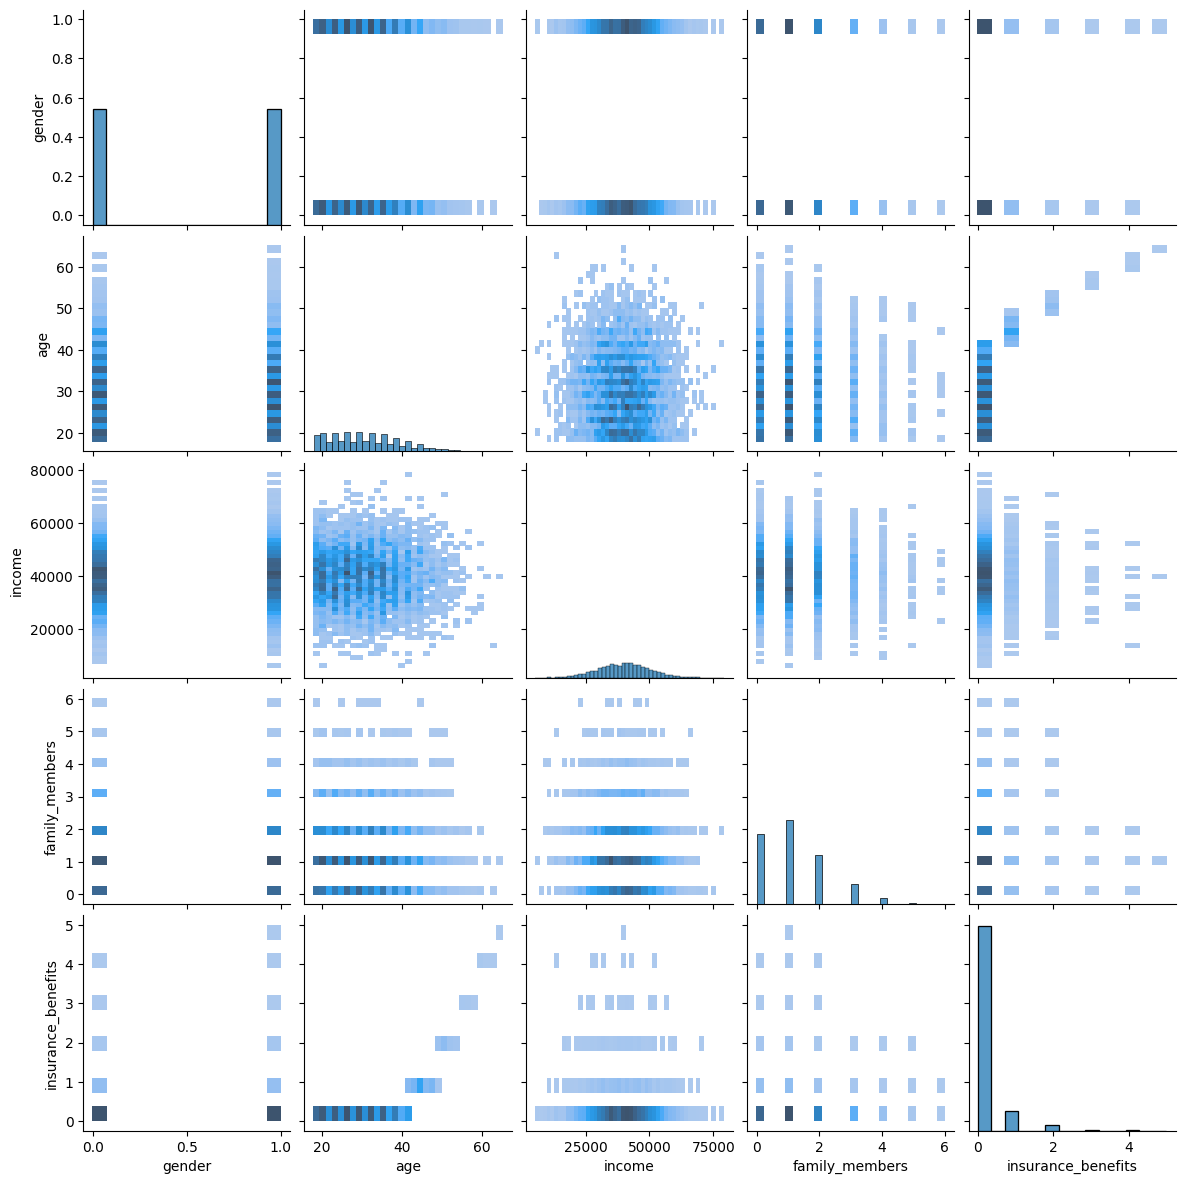

In [11]:
g = sns.pairplot(df, kind='hist')
g.fig.set_size_inches(12, 12)

Ok, it is a bit difficult to spot obvious groups (clusters) as it is difficult to combine several variables simultaneously (to analyze multivariate distributions). That's where LA and ML can be quite handy.

# Task 1. Similar Customers

In the language of ML, it is necessary to develop a procedure that returns k nearest neighbors (objects) for a given object based on the distance between the objects.

You may want to review the following lessons (chapter -> lesson)
- Distance Between Vectors -> Euclidean Distance
- Distance Between Vectors -> Manhattan Distance

To solve the task, we can try different distance metrics.

Write a function that returns k nearest neighbors for an $n^{th}$ object based on a specified distance metric. The number of received insurance benefits should not be taken into account for this task. 

You can use a ready implementation of the kNN algorithm from scikit-learn (check [the link](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors)) or use your own.

Test it for four combination of two cases
- Scaling
  - the data is not scaled
  - the data is scaled with the [MaxAbsScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html) scaler
- Distance Metrics
  - Euclidean
  - Manhattan

Answer these questions:
- Does the data being not scaled affect the kNN algorithm? If so, how does that appear?
- How similar are the results using the Manhattan distance metric (regardless of the scaling)?

In [12]:
feature_names = ['gender', 'age', 'income', 'family_members']

In [13]:
def get_knn(df, n, k, metric):
    
    """
    Returns k nearest neighbors

    :param df: pandas DataFrame used to find similar objects within
    :param n: object no for which the nearest neighbours are looked for
    :param k: the number of the nearest neighbours to return
    :param metric: name of distance metric
    """

    nbrs = sklearn.neighbors.NearestNeighbors(n_neighbors=k, metric=metric)
    nbrs.fit(df[feature_names])
    nbrs_distances, nbrs_indices = nbrs.kneighbors([df.iloc[n][feature_names]], k, return_distance=True)
    
    df_res = pd.concat([
        df.iloc[nbrs_indices[0]], 
        pd.DataFrame(nbrs_distances.T, index=nbrs_indices[0], columns=['distance'])
        ], axis=1)
    
    return df_res

Scaling the data.

In [14]:
feature_names = ['gender', 'age', 'income', 'family_members']

transformer_mas = sklearn.preprocessing.MaxAbsScaler().fit(df[feature_names].to_numpy())

df_scaled = df.copy()
df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())

In [15]:
df_scaled.sample(5)

,gender,age,income,family_members,insurance_benefits
4432,0.0,0.769231,0.493671,0.166667,2
2153,0.0,0.538462,0.497468,0.166667,0
573,1.0,0.692308,0.344304,0.166667,1
3688,1.0,0.600000,0.478481,0.166667,0
2343,1.0,0.723077,0.640506,0.166667,1


Now, let's get similar records for a given one for every combination

In [16]:
# Examine nearest neighbor examples for every combination of scaled and unscaled data and Euclidean and Manhattan distance
# I arbitrarily chose k = 5 and n = 5

print('output for k = 5, n = 5, metric = euclidean, and unscaled data:')
display(get_knn(df, 5, 5, 'euclidean'))
print()
print('output for k = 5, n = 5, metric = manhattan, and unscaled data:')
display(get_knn(df, 5, 5, 'manhattan'))
print()
print('output for k = 5, n = 5, metric = euclidean, and scaled data:')
display(get_knn(df_scaled, 5, 5, 'euclidean'))
print()
print('output for k = 5, n = 5, metric = manhattan, and scaled data:')
display(get_knn(df_scaled, 5, 5, 'manhattan'))

output for k = 5, n = 5, metric = euclidean, and unscaled data:


,gender,age,income,family_members,insurance_benefits,distance
5,1,43,41000.0,2,1,0.000000
1995,0,45,41000.0,0,1,3.000000
3972,1,40,41000.0,1,0,3.162278
3801,0,46,41000.0,2,1,3.162278
4763,1,46,41000.0,1,1,3.162278



output for k = 5, n = 5, metric = manhattan, and unscaled data:


,gender,age,income,family_members,insurance_benefits,distance
5,1,43,41000.0,2,1,0.0
3972,1,40,41000.0,1,0,4.0
4763,1,46,41000.0,1,1,4.0
3801,0,46,41000.0,2,1,4.0
1995,0,45,41000.0,0,1,5.0



output for k = 5, n = 5, metric = euclidean, and scaled data:


,gender,age,income,family_members,insurance_benefits,distance
5,1.0,0.661538,0.518987,0.333333,1,0.000000
1147,1.0,0.646154,0.516456,0.333333,0,0.015592
4074,1.0,0.661538,0.501266,0.333333,1,0.017722
1019,1.0,0.646154,0.501266,0.333333,0,0.023468
2962,1.0,0.630769,0.520253,0.333333,0,0.030795



output for k = 5, n = 5, metric = manhattan, and scaled data:


,gender,age,income,family_members,insurance_benefits,distance
5,1.0,0.661538,0.518987,0.333333,1,0.000000
4074,1.0,0.661538,0.501266,0.333333,1,0.017722
1147,1.0,0.646154,0.516456,0.333333,0,0.017916
2962,1.0,0.630769,0.520253,0.333333,0,0.032035
1019,1.0,0.646154,0.501266,0.333333,0,0.033106


In [17]:
# Examine a random nearest neighbor example for every combination of data and distance

rng = np.random.default_rng()
n = rng.integers(0, len(df))
print(f"output for k = 5, n = {n}, metric = euclidean, and unscaled data:")
display(get_knn(df, n, 5, 'euclidean'))
print()
print(f"output for k = 5, n = {n}, metric = manhattan, and unscaled data:")
display(get_knn(df, n, 5, 'manhattan'))
print()
print(f"output for k = 5, n = {n}, metric = euclidean, and scaled data:")
display(get_knn(df_scaled, n, 5, 'euclidean'))
print()
print(f"output for k = 5, n = {n}, metric = manhattan, and scaled data:")
display(get_knn(df_scaled, n, 5, 'manhattan'))

output for k = 5, n = 1432, metric = euclidean, and unscaled data:


,gender,age,income,family_members,insurance_benefits,distance
1432,1,21,41300.0,1,0,0.000000
2735,1,22,41300.0,1,0,1.000000
2114,1,21,41300.0,0,0,1.000000
4381,1,20,41300.0,2,0,1.414214
4922,1,23,41300.0,2,0,2.236068



output for k = 5, n = 1432, metric = manhattan, and unscaled data:


,gender,age,income,family_members,insurance_benefits,distance
1432,1,21,41300.0,1,0,0.0
2735,1,22,41300.0,1,0,1.0
2114,1,21,41300.0,0,0,1.0
4381,1,20,41300.0,2,0,2.0
2788,1,24,41300.0,1,0,3.0



output for k = 5, n = 1432, metric = euclidean, and scaled data:


,gender,age,income,family_members,insurance_benefits,distance
1432,1.0,0.323077,0.522785,0.166667,0,0.000000
639,1.0,0.323077,0.516456,0.166667,0,0.006329
1217,1.0,0.323077,0.529114,0.166667,0,0.006329
2120,1.0,0.323077,0.508861,0.166667,0,0.013924
4956,1.0,0.323077,0.507595,0.166667,0,0.015190



output for k = 5, n = 1432, metric = manhattan, and scaled data:


,gender,age,income,family_members,insurance_benefits,distance
1432,1.0,0.323077,0.522785,0.166667,0,0.000000
639,1.0,0.323077,0.516456,0.166667,0,0.006329
1217,1.0,0.323077,0.529114,0.166667,0,0.006329
2120,1.0,0.323077,0.508861,0.166667,0,0.013924
4956,1.0,0.323077,0.507595,0.166667,0,0.015190


Answers to the questions

**Does the data being not scaled affect the kNN algorithm? If so, how does that appear?** 

Scaling changes the results of the kNN algorithm because it uses the scales of the various columns to compute distances. Columns with larger numbers (e.g., feet or days) contribute more to the distance measure than those with smaller numbers (e.g., miles or weeks). Scaling the data gives each column equivalent magnitudes, ensuring that they contribute equally to the distance measure. 

**How similar are the results using the Manhattan distance metric (regardless of the scaling)?** 

The two metrics give similar but not identical results. In most cases, the k nearest neighbors include many of the same rows but they might be in a different order. 

# Task 2. Is Customer Likely to Receive Insurance Benefit?

In terms of machine learning we can look at this like a binary classification task.

With `insurance_benefits` being more than zero as the target, evaluate whether the kNN classification approach can do better than a dummy model.

Instructions:
- Build a KNN-based classifier and measure its quality with the F1 metric for k=1..10 for both the original data and the scaled one. That'd be interesting to see how k may influece the evaluation metric, and whether scaling the data makes any difference. You can use a ready implemention of the kNN classification algorithm from scikit-learn (check [the link](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)) or use your own.
- Build the dummy model which is just random for this case. It should return "1" with some probability. Let's test the model with four probability values: 0, the probability of paying any insurance benefit, 0.5, 1.

The probability of paying any insurance benefit can be defined as

$$
P\{\text{insurance benefit received}\}=\frac{\text{number of clients received any insurance benefit}}{\text{total number of clients}}.
$$

Split the whole data in the 70:30 proportion for the training/testing parts.

In [18]:
# calculate the target

df['insurance_benefits_received'] = df['insurance_benefits'].clip(upper=1)
df_scaled['insurance_benefits_received'] = df_scaled['insurance_benefits'].clip(upper=1)

In [19]:
# check for the class imbalance with value_counts()

display(df['insurance_benefits_received'].value_counts())
display(df_scaled['insurance_benefits_received'].value_counts())

0    4436
1     564
Name: insurance_benefits_received, dtype: int64

0    4436
1     564
Name: insurance_benefits_received, dtype: int64

In [20]:
def eval_classifier(y_true, y_pred):
    
    f1_score = sklearn.metrics.f1_score(y_true, y_pred)
    print(f'F1: {f1_score:.2f}')
    
# if you have an issue with the following line, restart the kernel and run the notebook again
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred, normalize='all')
    print('Confusion Matrix')
    print(cm)

In [21]:
# generating output of a random model

def rnd_model_predict(P, size, seed=42):

    rng = np.random.default_rng(seed=seed)
    return rng.binomial(n=1, p=P, size=size)

In [22]:
for P in [0, df['insurance_benefits_received'].sum() / len(df), 0.5, 1]:

    print(f'The probability: {P:.2f}')
    y_pred_rnd = rnd_model_predict(P, len(df))
        
    eval_classifier(df['insurance_benefits_received'], y_pred_rnd)
    
    print()

The probability: 0.00
F1: 0.00
Confusion Matrix
[[0.8872 0.    ]
 [0.1128 0.    ]]

The probability: 0.11
F1: 0.12
Confusion Matrix
[[0.7914 0.0958]
 [0.0994 0.0134]]

The probability: 0.50
F1: 0.20
Confusion Matrix
[[0.456  0.4312]
 [0.053  0.0598]]

The probability: 1.00
F1: 0.20
Confusion Matrix
[[0.     0.8872]
 [0.     0.1128]]



In [23]:
# Split both scaled and unscaled data into training and testing sets

features = df[feature_names]
features_scaled = df_scaled[feature_names]
target = df['insurance_benefits_received']

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.3, random_state=12345)
features_train_scaled = features_scaled.loc[features_train.index]
features_test_scaled = features_scaled.loc[features_test.index]

print('Unscaled')
print(f"Training set size: {len(features_train)}, {100*len(features_train)/len(df):.0f}%")
print(f"Test set size: {len(features_test)}, {100*len(features_test)/len(df):.0f}%")
print()
print('Scaled')
print(f"Training set size: {len(features_train_scaled)}, {100*len(features_train_scaled)/len(df_scaled):.0f}%")
print(f"Test set size: {len(features_test_scaled)}, {100*len(features_test_scaled)/len(df_scaled):.0f}%")

Unscaled
Training set size: 3500, 70%
Test set size: 1500, 30%

Scaled
Training set size: 3500, 70%
Test set size: 1500, 30%


In [24]:
# Train kNN models for k = 1 - 10 for unscaled data
    
print('Results for k nearest neighbors classifier with unscaled data')

for k in range(1, 11):
    neigh = sklearn.neighbors.KNeighborsClassifier(n_neighbors=k, metric='euclidean')
    neigh.fit(features_train, target_train)
    y_pred_knn = neigh.predict(features_test)
    f1_score = sklearn.metrics.f1_score(target_test, y_pred_knn)
    print(f"For k = {k}, F1 = {f1_score:.2f}")

Results for k nearest neighbors classifier with unscaled data
For k = 1, F1 = 0.61
For k = 2, F1 = 0.41
For k = 3, F1 = 0.41
For k = 4, F1 = 0.28
For k = 5, F1 = 0.27
For k = 6, F1 = 0.11
For k = 7, F1 = 0.11
For k = 8, F1 = 0.07
For k = 9, F1 = 0.08
For k = 10, F1 = 0.00


In [25]:
# Train kNN models for k = 1 - 10 for scaled data

print('Results for k nearest neighbors classifier with scaled data')

for k in range(1, 11):
    neigh = sklearn.neighbors.KNeighborsClassifier(n_neighbors=k, metric='euclidean')
    neigh.fit(features_train_scaled, target_train)
    y_pred_knn = neigh.predict(features_test_scaled)
    f1_score = sklearn.metrics.f1_score(target_test, y_pred_knn)
    print(f"For k = {k}, F1 = {f1_score:.2f}")

Results for k nearest neighbors classifier with scaled data
For k = 1, F1 = 0.97
For k = 2, F1 = 0.93
For k = 3, F1 = 0.95
For k = 4, F1 = 0.91
For k = 5, F1 = 0.92
For k = 6, F1 = 0.90
For k = 7, F1 = 0.92
For k = 8, F1 = 0.90
For k = 9, F1 = 0.92
For k = 10, F1 = 0.88


In [26]:
# Compare kNN models with dummy probability models

neigh = sklearn.neighbors.KNeighborsClassifier(n_neighbors=1, metric='euclidean')
neigh.fit(features_train, target_train)
print('K nearest nieghbor model (k = 1, data unscaled)')
eval_classifier(target_test, neigh.predict(features_test))
print()
    
neigh = sklearn.neighbors.KNeighborsClassifier(n_neighbors=1, metric='euclidean')
neigh.fit(features_train_scaled, target_train)
print('K nearest nieghbor model (k = 1, data scaled)')
eval_classifier(target_test, neigh.predict(features_test_scaled))
print()

for P in [0, target_train.sum() / len(target_train), 0.5, 1]:
    print(f'Probablity model (P = {P:.2f})')
    eval_classifier(target_train, rnd_model_predict(P, len(target_train)))
    print()

K nearest nieghbor model (k = 1, data unscaled)
F1: 0.61
Confusion Matrix
[[0.87       0.02133333]
 [0.052      0.05666667]]

K nearest nieghbor model (k = 1, data scaled)
F1: 0.97
Confusion Matrix
[[0.88866667 0.00266667]
 [0.00466667 0.104     ]]

Probablity model (P = 0.00)
F1: 0.00
Confusion Matrix
[[0.88542857 0.        ]
 [0.11457143 0.        ]]

Probablity model (P = 0.11)
F1: 0.11
Confusion Matrix
[[0.78171429 0.10371429]
 [0.102      0.01257143]]

Probablity model (P = 0.50)
F1: 0.17
Confusion Matrix
[[0.44171429 0.44371429]
 [0.06228571 0.05228571]]

Probablity model (P = 1.00)
F1: 0.21
Confusion Matrix
[[0.         0.88542857]
 [0.         0.11457143]]



The kNN models scored best with k = 1 and declined for greater values of k. The models performed much better on scaled data (best F1 = 0.97) than on unscaled data (best F1 = 0.61) and very nearly approached an ideal F1 score of 1, which indicates perfect accuracy and recall. The unscaled data declined precipitously, dropping to an F1 score of 0 by k = 10. The scaled data also declined but much more gradually and to a lesser extent, dropping only to an F1 score of 0.88 by k = 10. The fairly severe class imbalance may explain why lower k values had better scores; high values of k can quickly overwhelm the algorithm with irrelevant neighbors from the majority class. 

Both kNN models greatly outperformed all of the random models during testing. The best probability model had P = 1 (F1 = 0.21), followed by P = 0.5 (F1 = 0.17), P = 0.11 (F1 = 0.11), and finally P = 0 (F1 = 0). 

# Task 3. Regression (with Linear Regression)

With `insurance_benefits` as the target, evaluate what RMSE would be for a Linear Regression model.

Build your own implementation of LR. For that, recall how the linear regression task's solution is formulated in terms of LA. Check RMSE for both the original data and the scaled one. Can you see any difference in RMSE between these two cases?

Let's denote
- $X$ — feature matrix, each row is a case, each column is a feature, the first column consists of unities
- $y$ — target (a vector)
- $\hat{y}$ — estimated tagret (a vector)
- $w$ — weight vector

The task of linear regression in the language of matrices can be formulated as

$$
y = Xw
$$

The training objective then is to find such $w$ that it would minimize the L2-distance (MSE) between $Xw$ and $y$:

$$
\min_w d_2(Xw, y) \quad \text{or} \quad \min_w \text{MSE}(Xw, y)
$$

It appears that there is analytical solution for the above:

$$
w = (X^T X)^{-1} X^T y
$$

The formula above can be used to find the weights $w$ and the latter can be used to calculate predicted values

$$
\hat{y} = X_{val}w
$$

Split the whole data in the 70:30 proportion for the training/validation parts. Use the RMSE metric for the model evaluation.

In [27]:
class MyLinearRegression:
    
    def __init__(self):
        
        self.weights = None
    
    def fit(self, X, y):
        
        # adding the unities
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        self.weights = np.linalg.inv(X2.T.dot(X2)).dot(X2.T).dot(y)

    def predict(self, X):
        
        # adding the unities
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        y_pred = X2.dot(self.weights)
        
        return y_pred

In [28]:
def eval_regressor(y_true, y_pred):
    
    rmse = math.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    print(f'RMSE: {rmse:.2f}')
    
    r2_score = math.sqrt(sklearn.metrics.r2_score(y_true, y_pred))
    print(f'R2: {r2_score:.2f}')    

In [29]:
X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)
weights = [lr.weights]

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[-9.43539012e-01  3.57495491e-02  1.64272726e-02 -2.60743659e-07
 -1.16902127e-02]
RMSE: 0.34
R2: 0.66


In [30]:
# Run linear regression model again for scaled data

X = df_scaled[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df_scaled['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)
weights.append(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[-0.94353901  2.32372069  0.01642727 -0.02059875 -0.07014128]
RMSE: 0.34
R2: 0.66


In [31]:
# Compare regression weights for the scaled and unscaled models

print('Regression weights:')
display(pd.DataFrame(weights, index=['unscaled', 'scaled'], columns=['intercept', 'age', 'gender', 'income', 'family_members']))

Regression weights:


,intercept,age,gender,income,family_members
unscaled,-0.943539,0.035750,0.016427,-2.607437e-07,-0.011690
scaled,-0.943539,2.323721,0.016427,-2.059875e-02,-0.070141


The regression model worked as expected, predicting the insurance benefits with reasonable performance (RMSE = 0.34, $R^2$ = 0.66). The results were identical for scaled and unscaled data, but most of the regression weights were not. The weight for the gender feature remained the same because scaling did not affect its binary data. The intercept weight also remained the same because it automatically adjusted for feature scale. 

# Task 4. Obfuscating Data

It best to obfuscate data by multiplying the numerical features (remember, they can be seen as the matrix $X$) by an invertible matrix $P$. 

$$
X' = X \times P
$$

Try to do that and check how the features' values will look like after the transformation. By the way, the intertible property is important here so make sure that $P$ is indeed invertible.

You may want to review the 'Matrices and Matrix Operations -> Matrix Multiplication' lesson to recall the rule of matrix multiplication and its implementation with NumPy.

In [32]:
personal_info_column_list = ['gender', 'age', 'income', 'family_members']
df_pn = df[personal_info_column_list]

In [33]:
X = df_pn.to_numpy()

Generating a random matrix $P$.

In [34]:
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))

Checking the matrix $P$ is invertible

In [35]:
# Try to calculate the inverse of P

if np.linalg.det(P) != 0:
    print("The matrix is invertible.")
    
    P_inverse = np.linalg.inv(P)
    
    print('P^-1 = ')
    display(P_inverse)
else:
    print("The matrix is singular (non-invertible).")

The matrix is invertible.
P^-1 = 


array([[ 0.41467992, -1.43783972,  0.62798546,  1.14001268],
       [-1.06101789,  0.44219337,  0.1329549 ,  1.18425933],
       [ 1.42362442,  1.60461607, -2.0553823 , -1.53699695],
       [-0.11128575, -0.65813802,  1.74995517, -0.11816316]])

The matrix is invertible.

Can you guess the customers' ages or income after the transformation?

In [36]:
# Multiply X by P to obfuscate it

X_prime = X.dot(P)

print('X:')
display(pd.DataFrame(X, columns=['gender', 'age', 'income', 'family_members']))
print()
print("X':")
display(pd.DataFrame(X_prime, columns=['gender', 'age', 'income', 'family_members']))

X:


,gender,age,income,family_members
0,1.0,41.0,49600.0,1.0
1,0.0,46.0,38000.0,1.0
2,0.0,29.0,21000.0,0.0
3,0.0,21.0,41700.0,2.0
4,1.0,28.0,26100.0,0.0
...,...,...,...,...
4995,0.0,28.0,35700.0,2.0
4996,0.0,34.0,52400.0,1.0
4997,0.0,20.0,33900.0,2.0
4998,1.0,22.0,32700.0,3.0



X':


,gender,age,income,family_members
0,6359.715273,22380.404676,18424.090742,46000.696690
1,4873.294065,17160.367030,14125.780761,35253.455773
2,2693.117429,9486.397744,7808.831560,19484.860631
3,5345.603937,18803.227203,15479.148373,38663.061863
4,3347.176735,11782.829283,9699.998942,24211.273378
...,...,...,...,...
4995,4577.581382,16107.740932,13259.688205,33107.974380
4996,6717.000247,23634.217067,19456.138634,48589.438841
4997,4346.223425,15289.241265,12586.162644,31433.508886
4998,4194.093242,14751.991024,12144.029306,30323.887634


Customers' gender, age, income, and number of family members were successfully obfuscated. I cannot guess them. 

Can you recover the original data from $X'$ if you know $P$? Try to check that with calculations by moving $P$ from the right side of the formula above to the left one. The rules of matrix multiplcation are really helpful here.

In [37]:
# Recover the original X matrix from X'

X_recovered = X_prime.dot(P_inverse)

display(X_recovered)

array([[ 1.00000000e+00,  4.10000000e+01,  4.96000000e+04,
         1.00000000e+00],
       [-4.47363596e-12,  4.60000000e+01,  3.80000000e+04,
         1.00000000e+00],
       [-2.51586878e-12,  2.90000000e+01,  2.10000000e+04,
         9.52452315e-13],
       ...,
       [-1.92837871e-12,  2.00000000e+01,  3.39000000e+04,
         2.00000000e+00],
       [ 1.00000000e+00,  2.20000000e+01,  3.27000000e+04,
         3.00000000e+00],
       [ 1.00000000e+00,  2.80000000e+01,  4.06000000e+04,
         1.00000000e+00]])

Print all three cases for a few customers
- The original data
- The transformed one
- The reversed (recovered) one

In [38]:
# Compare X, X', and recovered X for a few customers
# I randomly chose observations 339, 1772, and 3891

for n in [339, 1772, 3891]:
    print('Regression weights for observation', n)
    display(pd.DataFrame({'X': X[n], "X'": X_prime[n], 'recovered X': X_recovered[n]}, index=['age', 'gender', 'income', 'family_members']).T)

Regression weights for observation 339


,age,gender,income,family_members
X,1.00000,54.000000,35400.0000,0.000000e+00
X',4541.08213,15996.784687,13168.2102,3.285063e+04
recovered X,1.00000,54.000000,35400.0000,3.218032e-12


Regression weights for observation 1772


,age,gender,income,family_members
X,1.000000,28.00000,33400.000000,0.000000e+00
X',4282.406253,15070.64663,12406.824519,3.097666e+04
recovered X,1.000000,28.00000,33400.000000,1.560230e-12


Regression weights for observation 3891


,age,gender,income,family_members
X,0.000000e+00,18.00000,18900.000000,1.000000
X',2.423687e+03,8530.67819,7022.226587,17530.234685
recovered X,-2.476057e-12,18.00000,18900.000000,1.000000


In [39]:
# Compare X, X', and recovered X for a random customer

n = rng.integers(0, len(df))

print('Regression weights for observation', n)
display(pd.DataFrame({'X': X[n], "X'": X_prime[n], 'recovered X': X_recovered[n]}, index=['age', 'gender', 'income', 'family_members']).T)

Regression weights for observation 460


,age,gender,income,family_members
X,1.000000,26.000000,31600.000000,3.000000
X',4053.544955,14260.468982,11739.196039,29307.590404
recovered X,1.000000,26.000000,31600.000000,3.000000


You can probably see that some values are not exactly the same as they are in the original data. What might be the reason for that?

The numerical values for the age and income features appear to be identical, but the binary values for the gender feature and the small integer values for the family_members feature sometimes changed very slightly from their original values. I presume those minuscule differences (on the order of $10^{-12}$) result from rounding error during the two computations. 

## Proof That Data Obfuscation Can Work with LR

The regression task has been solved with linear regression in this project. Your next task is to prove _analytically_ that the given obfuscation method won't affect linear regression in terms of predicted values i.e. their values will remain the same. Can you believe that? Well, you don't have to, you should prove it!

So, the data is obfuscated and there is $X \times P$ instead of just $X$ now. Consequently, there are other weights $w_P$ as
$$
w = (X^T X)^{-1} X^T y \quad \Rightarrow \quad w_P = [(XP)^T XP]^{-1} (XP)^T y
$$

How would $w$ and $w_P$ be linked if you simplify the formula for $w_P$ above? 

What would be predicted values with $w_P$? 

What does that mean for the quality of linear regression if you measure it with RMSE?

Check Appendix B Properties of Matrices in the end of the notebook. There are useful formulas in there!

No code is necessary in this section, only analytical explanation!

**Answer**

By simplifying the formula, I found that $w_P = P^{-1} w$. The obfuscated weights are simply the product of the original weights and the inverse of the obfuscation matrix P. 

Using the $w_P$ weights, $\hat{y}_P = \hat{y}$. The predicted values are identical because the $P$ matrix cancels out with its inverse (see below). 

With identical predicted values, the original and obfuscated linear regression models have identical RMSE scores because those are based on predictions and targets, not weights. 

**Analytical proof**

$$
w = (X^T X)^{-1} X^T y \quad \Rightarrow \quad w_P = [(XP)^T XP]^{-1} (XP)^T y
$$

$$
\begin{aligned}
    w_P &= [(XP)^T XP]^{-1} (XP)^T y \\
        &= [P^T X^T XP]^{-1} P^T X^T y \\
        &= P^{-1} [X^T X]^{-1} (P^T)^{-1} P^T X^T y \\
        &= P^{-1} [X^T X]^{-1} I X^T y \\
        &= P^{-1} [X^T X]^{-1} X^T y \\
        &= P^{-1} w
\end{aligned}
$$

$$
\hat{y} = X w \quad \Rightarrow \quad \hat{y}_P = XP w_P
$$

$$
\begin{aligned}
    \hat{y}_P &= XP w_P \\
            &= XP P^{-1} w \\
            &= X I w \\
            &= X w \\
            &= \hat{y}
\end{aligned}
$$

## Test Linear Regression With Data Obfuscation

Now, let's prove Linear Regression can work computationally with the chosen obfuscation transformation.

Build a procedure or a class that runs Linear Regression optionally with the obfuscation. You can use either a ready implementation of Linear Regression from sciki-learn or your own.

Run Linear Regression for the original data and the obfuscated one, compare the predicted values and the RMSE, $R^2$ metric values. Is there any difference?

**Procedure**

- Create a square matrix $P$ of random numbers.
- Check that it is invertible. If not, repeat the first point until we get an invertible matrix.
- Multiply the feature matrix $X$ by $P$
- Use $XP$ as the new feature matrix

In [40]:
# Create an obfuscated linear regression model class

class MyObfuscatedLinearRegression:
    
    def __init__(self):
        
        self.weights = None
        self.P = None
    
    def fit(self, X, y, obfuscate):
        
        if obfuscate == 1:
            det = 0
            rng = np.random.default_rng()

            while det == 0:
                P = rng.random(size=(X.shape[1], X.shape[1]))
                det = np.linalg.det(P)
                
            self.P = P
            X = X.dot(P)
        
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        self.weights = np.linalg.inv(X2.T.dot(X2)).dot(X2.T).dot(y)

    def predict(self, X):

        if self.P is not None:
            X = X.dot(self.P)
        
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        y_pred = X2.dot(self.weights)
        
        return y_pred

In [41]:
# Run obfuscated linear regression models with and without obfuscation 

X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

olr = MyObfuscatedLinearRegression()

olr.fit(X_train, y_train, 0)
weights_not_obf = olr.weights
pred_not_obf = olr.predict(X_test)

olr.fit(X_train, y_train, 1)
weights_obf = olr.weights
pred_obf = olr.predict(X_test)

results_obf = [math.sqrt(sklearn.metrics.mean_squared_error(y_test, pred_obf)), math.sqrt(sklearn.metrics.r2_score(y_test, pred_obf))]
results_not_obf = [math.sqrt(sklearn.metrics.mean_squared_error(y_test, pred_not_obf)), math.sqrt(sklearn.metrics.r2_score(y_test, pred_not_obf))]

print('Regression weights:')
display(pd.DataFrame({'obfuscated': weights_obf, 'not obfuscated': weights_not_obf}, index=['intercept', 'age', 'gender', 'income', 'family_members']).T)
print('Regression results:')
display(pd.DataFrame({'obfuscated': results_obf, 'not obfuscated': results_not_obf}, index=['RMSE', 'R2']).T)
print('Regression predictions:')
display(pd.DataFrame({'obfuscated': pred_obf, 'not obfuscated': pred_not_obf}))

Regression weights:


,intercept,age,gender,income,family_members
obfuscated,-0.943516,2.087071,-3.382117,1.214896e+00,0.466336
not obfuscated,-0.943539,0.035750,0.016427,-2.607437e-07,-0.011690


Regression results:


,RMSE,R2
obfuscated,0.343557,0.656146
not obfuscated,0.343557,0.656146


Regression predictions:


,obfuscated,not obfuscated
0,0.179269,0.179266
1,0.809312,0.809320
2,0.456129,0.456143
3,-0.237629,-0.237622
4,0.465004,0.465002
...,...,...
1495,0.084927,0.084932
1496,-0.073471,-0.073459
1497,-0.008718,-0.008705
1498,0.106803,0.106802


The results confirmed the analytical proof above. The obfuscated and unobfuscated linear regression models produced different weights but identical predictions and results (RMSE = 0.34, R2 = 0.66).

# Conclusions

The goal of this project was to use machine learning to analyze the Sure Tomorrow insurance company's customers. It entailed four tasks: find customers similar to a given customer using k nearest neighbor (kNN) clustering, predict whether a new customer is likely to use any insurance benefits using a kNN classifier, predict the number of insurance benefits likely to be used by a new customer using linear regression, and protect personal client data during the linear regression task. The data were suitable for modeling, lacking any missing values, outliers, or obvious distributional issues. 

To identify similar users, I employed a kNN algorithm with both scaled and unscaled data and both Euclidean and Manhattan distance metrics. Scaling affected the results because distance (between neighbors) depends on the scale of measurement. Features with larger numbers therefore have more influence on results than those with smaller numbers. Scaling ensures that every feature contributes equally to the distance measure. The distance metrics had some impact, but much less than scaling. Euclidean and Manhattan distances produced very similar lists of nearest neighbors, albeit sometimes with slightly different orders. 

The classifier model I created from the kNN algorithm was very effective. The kNN classifier with k = 1 and scaled data performed best (F1 = 0.97), followed by the kNN classifier with k = 1 and unscaled data (F1 = 0.61). Both kNN models handily outperformed four random dummy models with various probabilities (0, 0.11, 0.5, and 1) of predicting insurance benefit use, which had uniformly poor scores (F1 = 0, 0.11, 0.17, and 0.21, respectively).  

I created a linear regression model from scratch using linear algebra and it predicted the number of insurance benefits reasonably well (RMSE = 0.34, $R^2$ = 0.66). Although the regression weights differed, the performance for scaled and unscaled data were identical because linear regression results are generally invariant to linear transformations. 

To obfuscate customer data, I multiplied the features by a random invertible matrix before submitting them for linear regression. The original data could be recovered with the random matrix's inverse but not without it, protecting customer privacy. Obfuscation changed the regression weights, but not the predictions or the results of linear regression. I proved that both analytically and in practice. 

In conclusion, machine learning offers several useful tools for analyzing the Sure Tomorrow insurance company's customer data. Given a prospective customer, it can find similar customers, predict whether they will use any insurance benefits, and predict how many insurance benefits they will likely use while protecting personal data. 

# Checklist

Type 'x' to check. Then press Shift+Enter.

- [x]  Jupyter Notebook is open
- [x]  Code is error free
- [x]  The cells are arranged in order of logic and execution
- [x]  Task 1 has been performed
    - [x]  There is the procedure that can return k similar customers for a given one
    - [x]  The procedure is tested for all four proposed combinations
    - [x]  The questions re the scaling/distances are answered
- [x]  Task 2 has been performed
    - [x]  The random classification model is built and tested for all for probability levels
    - [x]  The kNN classification model is built and tested for both the original data and the scaled one, the F1 metric is calculated.
- [x]  Task 3 has been performed
    - [x]  The linear tegression solution is implemented with matrix operations.
    - [x]  RMSE is calculated for the implemented solution.
- [x]  Task 4 has been performed
    - [x]  The data is obfuscated with a random and invertible matrix P
    - [x]  The obfuscated data is recoved, few examples are printed out
    - [x]  The analytical proof that the transformation does not affect RMSE is provided 
    - [x]  The computational proof that the transformation does not affect RMSE is provided
- [x]  Conclusions have been made

# Appendices 

## Appendix A: Writing Formulas in Jupyter Notebooks

You can write formulas in your Jupyter Notebook in a markup language provided by a high-quality publishing system called $\LaTeX$ (pronounced "Lah-tech"), and they will look like formulas in textbooks.

To put a formula in a text, put the dollar sign (\\$) before and after the formula's text e.g. $\frac{1}{2} \times \frac{3}{2} = \frac{3}{4}$ or $y = x^2, x \ge 1$.

If a formula should be in its own paragraph, put the double dollar sign (\\$\\$) before and after the formula text e.g.

$$
\bar{x} = \frac{1}{n}\sum_{i=1}^{n} x_i.
$$

The markup language of [LaTeX](https://en.wikipedia.org/wiki/LaTeX) is very popular among people who use formulas in their articles, books and texts. It can be complex but its basics are easy. Check this two page [cheatsheet](http://tug.ctan.org/info/undergradmath/undergradmath.pdf) for learning how to compose the most common formulas.

## Appendix B: Properties of Matrices

Matrices have many properties in Linear Algebra. A few of them are listed here which can help with the analytical proof in this project.

<table>
<tr>
<td>Distributivity</td><td>$A(B+C)=AB+AC$</td>
</tr>
<tr>
<td>Non-commutativity</td><td>$AB \neq BA$</td>
</tr>
<tr>
<td>Associative property of multiplication</td><td>$(AB)C = A(BC)$</td>
</tr>
<tr>
<td>Multiplicative identity property</td><td>$IA = AI = A$</td>
</tr>
<tr>
<td></td><td>$A^{-1}A = AA^{-1} = I$
</td>
</tr>    
<tr>
<td></td><td>$(AB)^{-1} = B^{-1}A^{-1}$</td>
</tr>    
<tr>
<td>Reversivity of the transpose of a product of matrices,</td><td>$(AB)^T = B^TA^T$</td>
</tr>    
</table>